In [1]:
# # import all relevant libraries dependencies and set up the backend
# import time
# import IPython
# import numpy as np
# import matplotlib
# import math
# import pandas
# import pickle
# import subprocess
# import matplotlib.pyplot as plt
# %matplotlib inline

# import scipy
# import scipy.special 
# import scipy.optimize
# import scipy.sparse.linalg as LA
# import scipy.sparse as sparse
# from scipy.io import loadmat
# from scipy.optimize import curve_fit
# from scipy.signal import argrelextrema

# # add the ED.py functions to the notebook
# import sys
# #import hubbard as ED 

import numpy as np
import time
import scipy
import scipy.special
import scipy.sparse.linalg as LA
import scipy.sparse as sparse
import copy
import warnings
import matplotlib
import matplotlib.pyplot as plt


from matplotlib import animation, rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':12})
# rc('font',**{'family':'serif','serif':['FreeSerif'],'size':12})
rc('text', usetex=True)
from cycler import cycler

c1_a = '#003AF0'
c2_a = '#008F24'
c3_a = '#FE7B22'
c4_a = '#FE000C'
c5_a = '#FB30F2'
c6_a = '#82E0AA' #'#FFE135'
c7_a = '#9966CC'
c8_a = '#7FFFD4'
c9_a = '#66FF00'
c10_a = '#8B008B'
c11_a = '#000000'
colours = [c1_a,c2_a,c3_a,c4_a,c5_a,c6_a,c7_a,c8_a,c9_a,c10_a,c11_a]

matplotlib.rcParams['backend'] = 'MacOSX'
matplotlib.rcParams['savefig.dpi'] = 250
matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['text.latex.unicode']=True
matplotlib.rcParams['axes.prop_cycle'] = cycler('color',colours)
# matplotlib.rcParams['axes.'] = \in\
# matplotlib.rcParams['legend.fancybox']=True
matplotlib.rcParams['legend.frameon'] = False
matplotlib.rcParams['legend.fontsize'] = 12
matplotlib.rcParams['figure.figsize'] = (10,8)
# matplotlib.rcParams['axes.color_cycle'] = colors
# matplotlib.rcParams['axes.prop_cycle'] = colors

In [2]:
def state_to_int(p, statelist):
    """
    Converts array of spin-configuration into integer
    Args:
        p - dictionary that contains the relevant system parameters
        statelist - spin configuration (binary)
    Returns:
        out - integer corresponding to state
    """
    # convert statelist to string
    state = ''.join([str(s) for s in statelist])
    # construct unique integer for the fermion configuration defined
    # in statelist
    out = int(state,2)
    return out


def int_to_state(p, state_number):
    """
    Converts integer to array of spin-configuration
    Args:
        p - dictionary that contains the relevant system parameters
        state_number - integer corresponding to state
    Returns:
        statelist - fermion configuration
    """

    # convert integer to spin configuration of length L (binary representation)
    statelist = format(state_number,"0%sb"%(p['N']))
    # remove the 0b tag at the beginning
    statelist = [int(s) for s in statelist]
    return statelist


def generate_state_table(p):
    """
    generates table of state-integers of the full Hilbertspace
    Args:
        p - dictionary that contains the relevant system parameters
    Returns:
        state_table - list of all state_numbers that belong to the Hilbertspace
    """
    # generate list of state_numbers which are allowed by the symmetries
    state_table = []
    if p['Symmetry'] == None:
        # generate full Hilbert space
        for i in range(int(2**p['N'])):
            state_table.append(i)
    else:
        # Sz != None, i.e. choose specific symmetry sector
        for i in range(int(2**p['N'])):
            if np.sum(np.asarray(int_to_state(p, i)) - 0.5) == p['Symmetry']:
                state_table.append(i)
        
    return state_table
    

def transverse_field_matrix(p, state_table):
    """
    generates the full transverse field interaction matrix
    Args:
        p - dictionary that contains the relevant system parameters
        state_table - list of all state_numbers that belong to the Hilbertspace
    Returns:
        transverse_field - interaction matrix on the Hilbertspace
    """
    
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])

        # iterate through the chain and flip each spin with application of X
        for i in range(len(state)):
            outstate = copy.deepcopy(state)
            
            # flip local spin (X)
            outstate[i] = 0 if outstate[i] else 1
            
            # get new state number
            Out = state_table.index(state_to_int(p, outstate))
            
            # get matrix element (note Sx = 1/2*X)
            matrixelement = -0.5 * p['hx']
            
            # store matrix element
            row.append(Out)
            col.append(In)
            data.append(matrixelement)
            
            del matrixelement

    transverse_field = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return transverse_field


def longitudinal_field_matrix(p, state_table):
    """
    generates the full longitudinal field interaction matrix
    Args:
        p - dictionary that contains the relevant system parameters
        state_table - list of all state_numbers that belong to the Hilbertspace
    Returns:
        longitudinal_field - interaction matrix on the Hilbertspace
    """
        
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])
        
        # eigenvalue of |0> is -1/2 and |1> is 1/2 so transform state (binary code) to spin basis
        spin = np.asarray(state) - 0.5

        # get matrix element
        matrixelement = -1.0 * p['hz'] * np.sum(spin)
            
        # store matrix element (note hz is diagonal so Out = In)
        row.append(In)
        col.append(In)
        data.append(matrixelement)
            
        del matrixelement
        
    longitudinal_field = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return longitudinal_field


def ZZinteraction_matrix(p, state_table):
    """
    generates the full ZZ interaction matrix
    Args:
        p - dictionary that contains the relevant system parameters
        state_table - list of all state_numbers that belong to the Hilbertspace
    Returns:
        ZZ_interaction - ZZ interaction matrix on the Hilbertspace
    """
    
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])
        
        # eigenvalue of |0> is -1/2 and |1> is 1/2 so transform state (binary code) to spin basis
        spin = np.asarray(state) - 0.5
            
        # multiply nearest neighbour ZZ interaction term
        ZiZj = spin[1:] * spin[:-1]
        
        # get matrix element
        matrixelement = -1.0 * p['Jz'] * np.sum(ZiZj)
            
        # store matrix element (note hz is diagonal so Out = In)
        row.append(In)
        col.append(In)
        data.append(matrixelement)
            
        del matrixelement, ZiZj
        
    ZZ_interaction = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return ZZ_interaction


def spinflip_matrix(p, state_table):
    """
    generates the full 0.5*(S(i,+)S(i+1,-) + S(i,-)S(i+1,+)) interaction matrix
    Args:
        p - dictionary that contains the relevant system parameters
        state_table - list of all state_numbers that belong to the Hilbertspace
    Returns:
        spinflip_interaction - spinflip interaction matrix on the Hilbertspace
    """
    
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])

        # iterate through the chain and swap adjacent spins if they are anti-alligned
        for i in range(len(state)-1):
            if state[i] != state[i+1]:
                outstate = copy.deepcopy(state)

                # swap spins and sites (i,i+1)
                outstate[i] = 0 if outstate[i] else 1
                outstate[i+1] = 0 if outstate[i+1] else 1

                # get new state number
                Out = state_table.index(state_to_int(p, outstate))

                # get matrix element
                matrixelement = -0.5 * p['Jx']

                # store matrix element
                row.append(Out)
                col.append(In)
                data.append(matrixelement)

                del matrixelement
        
    spinflip_interaction = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return spinflip_interaction


def longrange_spinflip_matrix(p, i, j, state_table):
    """
    generates the full (S(i,+)S(j,-) + S(i,-)S(j,+)) interaction matrix
    Args:
        p - dictionary that contains the relevant system parameters
        i - site 1
        j - site 2
        state_table - list of all state_numbers that belong to the Hilbertspace
    Returns:
        longrange_spinflip_interaction - spinflip interaction matrix on the Hilbertspace
    """
    
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])

        # can only swap spins on sites (i,j) if they are 'anti-alligned'
        if state[i] != state[j]:
            outstate = copy.deepcopy(state)

            # swap spins and sites (i,i+1)
            outstate[i] = 0 if outstate[i] else 1
            outstate[j] = 0 if outstate[j] else 1

            # get new state number
            Out = state_table.index(state_to_int(p, outstate))

            # get matrix element
            matrixelement = 1.0

            # store matrix element
            row.append(Out)
            col.append(In)
            data.append(matrixelement)

            del matrixelement
        
    longrange_spinflip_interaction = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return longrange_spinflip_interaction


def make_Hamiltonian(p, state_table):
    """
    Generates full Hamiltonian on the full Hilbertspace
    Args:
        p - dictionary that contains the relevant system parameters
        state_table - list of all state_numbers that belong to the Hilbertspace
    Returns:
        H - Hamiltonian matrix on the full Hilbertspace
    """
    dim = len(state_table)
    row = []
    col = []
    data = []

    H = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    H = longitudinal_field_matrix(p, state_table)
    if p['Symmetry'] == None:
        H += transverse_field_matrix(p, state_table)
    H += spinflip_matrix(p, state_table)
    H += ZZinteraction_matrix(p, state_table)

    return H


def calculate_gs(p):
    """
    calculates groundstate of full Hamiltonian on the full Hilbertspace
    Args:
        p - dictionary that contains the relevant system parameters for the GS search
    Returns:
        E0 - GS energy
        gs - GS vector on the relevant Hilbertspace subspace
        state_table - list of all state_numbers that belong to the full Hilbertspace
    """
    state_table = generate_state_table(p)
    H = make_Hamiltonian(p, state_table)
    w, v = scipy.sparse.linalg.eigsh(H, k=1, which='SA')

    return w[0], v[:, 0], state_table


def expct_val(Op, psi):
    """
    compute expecation value of operator 'Op' with state 'psi'
    Args:
        Op - operator corresponding to observable to be measured
        psi - state-vector (on sub-Hilbertspace)
    Returns:
        <psi| Op |psi>
    """
    return (psi.conj().T).dot(Op.dot(psi))


def matrix_elements(Op, bra, ket):
    """
    compute matrix element of operator 'Op' with state 'bra' form the left and 'ket' from the right
    Args:
        Op - operator corresponding to observable to be measured
        bra - adjoint (left/outgoing) state
        ket - (right/incoming) state
    Returns:
        <bra| Op |ket>
    """
    return (bra.conj().T).dot(Op.dot(ket))


def Sz_matrix(p, site, state_table):
    """
    generates the matrix corresponding to the operator Sz_{i}
    Args:
        p - dictionary that contains the relevant system parameters
        site - site on which Sz is to be evaluated (from 0 to L-1)
        state_table - list of all state_numbers that belong to the full Hilbertspace
    Returns:
        Sz - Sz_{i} matrix on the relevant Hilbertspace
    """
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])
        
        # eigenvalue of |0> is -1/2 and |1> is 1/2 so transform state (binary code) to spin basis
        spin = np.asarray(state) - 0.5

        matrixelement = spin[site]
        # store matrix element
        if matrixelement != 0.0:
            row.append(In)
            col.append(In)
            data.append(matrixelement)

        del matrixelement

    Sz = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return Sz


def Sx_matrix(p, site, state_table):
    """
    generates the matrix corresponding to the operator Sx_{i}
    Args:
        p - dictionary that contains the relevant system parameters
        site - site on which Sx is to be evaluated (from 0 to L-1)
        state_table - list of all state_numbers that belong to the full Hilbertspace
    Returns:
        Sx - Sx_{i} matrix on the relevant Hilbertspace
    """
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])
        
        outstate = copy.deepcopy(state)
            
        # flip local spin (Sx = 1/2*X) at site 
        outstate[site] = 0 if outstate[site] else 1
            
        # get new state number
        Out = state_table.index(state_to_int(p, outstate))
            
        # get matrix element
        matrixelement = 0.5
            
        # store matrix element
        row.append(Out)
        col.append(In)
        data.append(matrixelement)
            
        del matrixelement
        
    Sx = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return Sx


def Sy_matrix(p, site, state_table):
    """
    generates the matrix corresponding to the operator Sy_{i}
    Args:
        p - dictionary that contains the relevant system parameters
        site - site on which Sy is to be evaluated (from 0 to L-1)
        state_table - list of all state_numbers that belong to the full Hilbertspace
    Returns:
        Sy - Sy_{i} matrix on the relevant Hilbertspace
    """
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])
        
        outstate = copy.deepcopy(state)
            
        # flip local spin (Sy = 1/2*Y) at site 
        outstate[site] = 0 if outstate[site] else 1
            
        # get new state number
        Out = state_table.index(state_to_int(p, outstate))
            
        # get matrix element (-i if initially state = 0 else i)
        matrixelement = 1.j if state[site] else -1.j
            
        # store matrix element
        row.append(Out)
        col.append(In)
        data.append(matrixelement)
            
        del matrixelement
        
    Sy = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return Sy


def Sp_matrix(p, site, state_table):
    """
    generates the matrix corresponding to the operator S+_{i}
    Args:
        p - dictionary that contains the relevant system parameters
        site - site on which S+ is to be evaluated (from 0 to L-1)
        state_table - list of all state_numbers that belong to the full Hilbertspace
    Returns:
        Splus - S+_{i} matrix on the relevant Hilbertspace
    """
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])
        
        outstate = copy.deepcopy(state)
        
        if not(outstate[site]):
            # raise local spin (S+ = Sx + i Sy) at site
            outstate[site] = 1

            # get new state number
            Out = state_table.index(state_to_int(p, outstate))

            # get matrix element
            matrixelement = 1.0

            # store matrix element
            row.append(Out)
            col.append(In)
            data.append(matrixelement)

            del matrixelement
        
    Splus = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return Splus


def Sm_matrix(p, site, state_table):
    """
    generates the matrix corresponding to the operator S-_{i}
    Args:
        p - dictionary that contains the relevant system parameters
        site - site on which S- is to be evaluated (from 0 to L-1)
        state_table - list of all state_numbers that belong to the full Hilbertspace
    Returns:
        Sminus - S-_{i} matrix on the relevant Hilbertspace
    """
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])
        
        outstate = copy.deepcopy(state)
        
        if outstate[site]:
            # lower local spin (S- = Sx - i Sy) at site
            outstate[site] = 0

            # get new state number
            Out = state_table.index(state_to_int(p, outstate))

            # get matrix element
            matrixelement = 1.0

            # store matrix element
            row.append(Out)
            col.append(In)
            data.append(matrixelement)

            del matrixelement
        
    Sminus = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return Sminus


def build_densitymatrix(psi):
    """
    build the density matrix from a pure state psi
    Args:
        psi - state-vector (on full Hilbertspace)
    Returns:
        rho = |psi><psi|
    """
    
    # reshape psi0 into vector form of dimension (dim,1)
    psi = np.reshape(psi, (len(psi),1))
    
    return psi.dot(psi.conj().T)


def purification(rho):
    """
    purify the density matrix into vector form
    Args:
        rho - density matrix (on  full Hilbertspace)
    Returns:
        rho_vec = |psi>|psi>
    """

    return rho.flatten(order='C')


def depurification(rho_vec):
    """
    depurify the density matrix vector back into density matrix shape
    Args:
        rho_vec - density matrix vector (on  full Hilbertspace)
    Returns:
        rho = |psi><psi|
    """
    
    # dimension of Hilbert space is sqrt of the vector size
    dim = int(np.sqrt(np.size(rho_vec)))
    return rho_vec.reshape(dim,dim)


def quantum_fisher_info(rho, op, tol):
    """
    compute the Quantum Fisher Information for operator op and density matrix rho
    Args:
        rho - density matrix (either in standard or purified form)
        op - measurement operator on the full Hilbert space
        tol - tolerance to check the purity of the density matrix and which eigenvalues to sum in the QFI
    Returns:
        QFI - Quantum Fisher Information
        purity - Purity of the density matrix. If purity=-1 we use the full QFI computation, 
                    else the variance for pure state
    """
    
    # if rho is in purified form, bring it to standard form
    if np.size(rho) == np.shape(rho)[0]:
        rho = depurification(rho)
    
    # check if rho is truly a square hermitian matrix with trace 1
    try:
        np.shape(rho)[0] == np.shape(rho)[1] and np.allclose(rho.conj().T, rho, rtol=0.0, atol=tol) and \
            np.trace(rho) == 1.0
    except AsymmetricMatrixError:
        print("Not a square density matrix")
    
    # check the purity of the state
    purity = np.trace(rho.dot(rho))
    
    # compute the quantum fisher information
    QFI = 0.
        
    # diagonalise rho and get eigenvalues and right eigenvectors
    Eval, rEvec = scipy.linalg.eigh(rho)
    for i in range(len(Eval)):
        for j in range(len(Eval)):
            if np.real(Eval[i] + Eval[j]) > tol:
                # only sum over at least one non-zero eigenvalue
                prefactor = 2 / np.real(Eval[i] + Eval[j]) * np.real(Eval[i] - Eval[j])**2
                QFI += prefactor * np.abs(matrix_elements(op, rEvec[:,i], rEvec[:,j]))**2
            else:
                continue

    return QFI, purity


def build_LindbladMatrix(p):
    """
    build Lindblad matrix acting on purified density matrix
    Args:
        p - dictionary that contains the relevant system parameters
    Returns:
        L - Lindblad matrix on the (full * auxiliary) state space
    """

    # set up basis states and Hilbert space
    state_table = generate_state_table(p)
    dim = len(state_table)
    I = sparse.csr_matrix(np.eye(dim))
    
    # make Hamiltonian
    H = make_Hamiltonian(p, state_table)
    
    # make jump operators
    jump_op = {}
    for i in range(p['N']):
        # Sx
        if p['Symmetry'] == None and p['gamma_Sx'] != 0.0:
            jump_op['Sx(%s)' % (i)] = Sx_matrix(p, i, state_table)
            
        # Sz
        jump_op['Sz(%s)' % (i)] = Sz_matrix(p, i, state_table)
        
        # Splus
        if p['Symmetry'] == None and p['gamma_Sp'] != 0.0:
            jump_op['Sp(%s)' % (i)] = Sp_matrix(p, i, state_table)
            
        # Sminus
        if p['Symmetry'] == None and p['gamma_Sm'] != 0.0:
            jump_op['Sm(%s)' % (i)] = Sm_matrix(p, i, state_table)
    
    # build L
    L = -1j * sparse.kron(H, I) + 1j * sparse.kron(I, H.T)
    
    for op in jump_op:
        L += p['gamma_%s' % op[:2]] * sparse.kron(jump_op[op], (jump_op[op].conj().T).T)
        L += -0.5 * p['gamma_%s' % op[:2]] * sparse.kron((jump_op[op].conj().T).dot(jump_op[op]), I)
        L += -0.5 * p['gamma_%s' % op[:2]] * sparse.kron(I, ((jump_op[op].conj().T).dot(jump_op[op])).T)
        
    return L


def evolve_purification(p, state_table, rho0, kind="matrix"):
    """
    evolve purified density matrix 'rho' under parameters defined in dictionary 'p'
    Args:
        p - dictionary that contains the relevant system parameters for time-evolution
        state_table - list of all basis states (int) in the full Hilbert space
        rho - initial density matrix in purified form
        kind - how the state is passed to the function: 
                kind="list" spin-configuration (productstate) OR 
                kind="int" the unique state id in the state_table OR
                kind="matrix" (default) regular density matrix OR 
                kind="purified" the purified density matrix vector
    Returns:
        sim - dictionary with the relevant measurements: Sx, Sy, Sz, FI
        state_table - list of all state_numbers that belong to the full Hilbertspace
    """
    
    if kind == "list":
        # if we parsed a product state, construct ket by identifying the
        # corresponding number of the basis state and putting a 1 into the ket
        # and then build density matrix and its purified form from it
        psi0 = np.zeros((len(state_table), 1), dtype=complex)
        psi0[state_table.index(state_to_int(p, rho0))] = 1.
        rho = build_densitymatrix(psi0)
    elif kind == "int":
        psi0 = np.zeros((len(state_table), 1), dtype=complex)
        psi0[state_table.index(rho)] = 1.
        rho = build_densitymatrix(psi0)
    elif kind == "matrix":
        rho = purification(rho0)
    elif kind == "purified":
        rho = rho0

    time = np.arange(start=p['t_initial'], stop=(p['t_final'] + p['dt']), step=p['dt'])

    # make dictionary with measurement operators
    meas = {}
    for i in range(int(p['N'])):
        if p['Symmetry'] == None:
            meas['Sx(%s)' % (i)] = Sx_matrix(p, i, state_table).toarray()
            meas['Sy(%s)' % (i)] = Sy_matrix(p, i, state_table).toarray()
        meas['Sz(%s)' % (i)] = Sz_matrix(p, i, state_table).toarray()
        # total spin
        if i == 0:
            if p['Symmetry'] == None:
                meas['SxTotal'] = meas['Sx(%s)' % (i)]
                meas['SyTotal'] = meas['Sy(%s)' % (i)]
            meas['SzTotal'] = meas['Sz(%s)' % (i)]
        else:
            if p['Symmetry'] == None:
                meas['SxTotal'] = meas['SxTotal'] + meas['Sx(%s)' % (i)]
                meas['SyTotal'] = meas['SyTotal'] + meas['Sy(%s)' % (i)]
            meas['SzTotal'] = meas['SzTotal'] + meas['Sz(%s)' % (i)]
        
    sim = {}
    sim['Time'] = time
    sim['Purity'] = np.zeros(np.shape(time), dtype=complex)
    for key in meas.keys():
        sim[key] = np.zeros(np.shape(time), dtype=complex)
        
    if p['Symmetry'] == None:
        sim['QFI_TotalSx'] = np.zeros(np.shape(time), dtype=complex)
        sim['QFI_TotalSy'] = np.zeros(np.shape(time), dtype=complex)
        sim['Var(TotalSx)'] = np.zeros(np.shape(time), dtype=complex)
        sim['Var(TotalSy)'] = np.zeros(np.shape(time), dtype=complex)
    sim['QFI_TotalSz'] = np.zeros(np.shape(time), dtype=complex)
    sim['Var(TotalSz)'] = np.zeros(np.shape(time), dtype=complex)

    # build Lindblad superoperator
    L = build_LindbladMatrix(p)
    
    # construct time-evolution operator
    Eval, Evec = scipy.linalg.eig(L.toarray(), right=True)
    U = Evec.dot(np.diag(np.exp(Eval*p['dt'])).dot(scipy.linalg.inv(Evec)))

    # Time Evolution
    for i in range(len(time)):
        # measurements
        for operator in meas.keys():
            sim[operator][i] = np.trace(rho.dot(meas[operator]))
        
        if p['Symmetry'] == None:
            sim['QFI_TotalSx'][i] = quantum_fisher_info(rho, meas['SxTotal'], tol=p['tol'])[0]
            sim['QFI_TotalSy'][i] = quantum_fisher_info(rho, meas['SyTotal'], tol=p['tol'])[0]
            sim['Var(TotalSx)'][i] = np.trace(rho.dot(meas['SxTotal'].dot(meas['SxTotal']))) - \
                                            (sim['SxTotal'][i])**2
            sim['Var(TotalSy)'][i] = np.trace(rho.dot(meas['SyTotal'].dot(meas['SyTotal']))) - \
                                            (sim['SyTotal'][i])**2
        sim['QFI_TotalSz'][i], sim['Purity'][i] = quantum_fisher_info(rho, meas['SzTotal'], tol=p['tol'])
        sim['Var(TotalSz)'][i] = np.trace(rho.dot(meas['SzTotal'].dot(meas['SzTotal']))) - (sim['SzTotal'][i])**2

        # apply U to current state rho to get rho(t+dt) = U * rho(t)
        rho_vec = purification(rho)
        rho_vec = U.dot(rho_vec)
        rho = depurification(rho_vec)
        
    return sim, state_table


def evolve_single_trajectory(p, state_table, psi0, kind="vector"):
    """
    evolve purified density matrix 'rho' under parameters defined in dictionary 'p'
    Args:
        p - dictionary that contains the relevant system parameters for time-evolution
        state_table - list of all basis states (int) in the full Hilbert space
        psi0 - initial state
        kind - how the state is passed to the function: 
                kind="list" spin-configuration (productstate) OR 
                kind="int" the unique state id in the state_table OR
                kind="vector" (default) state vector on full Hilbert space
    Returns:
        sim - dictionary with the relevant measurements: Sx, Sy, Sz, FI
        state_table - list of all state_numbers that belong to the full Hilbertspace
    """
    
    if kind == "list":
        # if we parsed a product state, construct ket by identifying the
        # corresponding number of the basis state and putting a 1 into the ket
        # and then build density matrix and its purified form from it
        psi = np.zeros((len(state_table), 1), dtype=complex)
        psi[state_table.index(state_to_int(p, psi0))] = 1.
    elif kind == "int":
        psi = np.zeros((len(state_table), 1), dtype=complex)
        psi[state_table.index(psi0)] = 1.
    elif kind == "vector":
        psi = psi0

    time = np.arange(start=p['t_initial'], stop=(p['t_final'] + p['dt']), step=p['dt'])

    # make dictionary with measurement operators
    meas = {}
    for i in range(int(p['N'])):
        if p['Symmetry'] == None:
            # can only generate these matrices on full Hilbert space as they change quantum number sector
            meas['Sx(%s)' % (i)] = Sx_matrix(p, i, state_table).toarray()
            meas['Sy(%s)' % (i)] = Sy_matrix(p, i, state_table).toarray()
        meas['Sz(%s)' % (i)] = Sz_matrix(p, i, state_table).toarray()
        # total spin
        if i == 0:
            if p['Symmetry'] == None:
                # can only generate these matrices on full Hilbert space as they change quantum number sector
                meas['SxTotal'] = meas['Sx(%s)' % (i)]
                meas['SyTotal'] = meas['Sy(%s)' % (i)]
            meas['SzTotal'] = meas['Sz(%s)' % (i)]
        else:
            if p['Symmetry'] == None:
                # can only generate these matrices on full Hilbert space as they change quantum number sector
                meas['SxTotal'] = meas['SxTotal'] + meas['Sx(%s)' % (i)]
                meas['SyTotal'] = meas['SyTotal'] + meas['Sy(%s)' % (i)]
            meas['SzTotal'] = meas['SzTotal'] + meas['Sz(%s)' % (i)]
        
    sim = {}
    sim['Time'] = time
    sim['Purity'] = np.zeros(np.shape(time), dtype=complex)
    for key in meas.keys():
        sim[key] = np.zeros(np.shape(time), dtype=complex)

    if p['Symmetry'] == None:
        # can only generate these matrices on full Hilbert space as they change quantum number sector
        sim['QFI_TotalSx'] = np.zeros(np.shape(time), dtype=complex)
        sim['QFI_TotalSy'] = np.zeros(np.shape(time), dtype=complex)
        sim['Var(TotalSx)'] = np.zeros(np.shape(time), dtype=complex)
        sim['Var(TotalSy)'] = np.zeros(np.shape(time), dtype=complex)
    sim['QFI_TotalSz'] = np.zeros(np.shape(time), dtype=complex)
    sim['Var(TotalSz)'] = np.zeros(np.shape(time), dtype=complex)

    # build Hamiltonian
    H = make_Hamiltonian(p, state_table)
    
    # make jump operators
    jump_op = {}
    for i in range(p['N']):
        # Sx
        if p['Symmetry'] == None and p['gamma_Sx'] != 0.0:
            jump_op['Sx(%s)' % (i)] = Sx_matrix(p, i, state_table)
            
        # Sz
        jump_op['Sz(%s)' % (i)] = Sz_matrix(p, i, state_table)
        
        # Splus
        if p['Symmetry'] == None and p['gamma_Sp'] != 0.0:
            jump_op['Sp(%s)' % (i)] = Sp_matrix(p, i, state_table)
            
        # Sminus
        if p['Symmetry'] == None and p['gamma_Sm'] != 0.0:
            jump_op['Sm(%s)' % (i)] = Sm_matrix(p, i, state_table)
    
    # build Heff
    Heff = H
    for op in jump_op:
        Heff += -0.5j * p['gamma_%s' % op[:2]] * (jump_op[op].conj().T).dot(jump_op[op])
    
    # construct time-evolution operator
    # Ueff = LA.expm(-1.j * Heff.tocsc() * p['dt'])
    Ueff = scipy.sparse.identity(np.size(psi)) - 1.j * p['dt'] * Heff

    # Time Evolution
    for i in range(len(time)):
        norm = np.sqrt((psi.conj().T).dot(psi))
        # measurements
        for operator in meas.keys():
            sim[operator][i] = expct_val(meas[operator], psi/norm)
        
        if p['Symmetry'] == None:
            sim['QFI_TotalSx'][i] = quantum_fisher_info(build_densitymatrix(psi/norm), \
                                                        meas['SxTotal'], tol=p['tol'])[0]
            sim['QFI_TotalSy'][i] = quantum_fisher_info(build_densitymatrix(psi/norm), \
                                                        meas['SyTotal'], tol=p['tol'])[0]
            sim['Var(TotalSx)'][i] = expct_val(meas['SxTotal'].dot(meas['SxTotal']), \
                                               psi/norm) - (sim['SxTotal'][i])**2
            sim['Var(TotalSy)'][i] = expct_val(meas['SyTotal'].dot(meas['SyTotal']), \
                                               psi/norm) - (sim['SyTotal'][i])**2
        sim['QFI_TotalSz'][i], sim['Purity'][i] = quantum_fisher_info(build_densitymatrix(psi/norm), \
                                                                      meas['SzTotal'], tol=p['tol'])
        sim['Var(TotalSz)'][i] = expct_val(meas['SzTotal'].dot(meas['SzTotal']), \
                                           psi/norm) - (sim['SzTotal'][i])**2

        # choose random number eta to establish when to apply the next jump
        eta = np.random.rand(1)[0]
        
        # stochastic unravelling of the master equation: check norm of phi = psi(t+dt) = Ueff * psi(t)
        phi = Ueff.dot(psi)
        if eta <= (1 - (phi.conj().T).dot(phi)):
            # (A) stochastically apply jump operator instead of time-evolution for a single time-step
            # with probability p = 1 - ||psi(t+dt)||^2
            
            # generate jump probability distribution
            jump_probability = np.empty(0) 
            for op in jump_op:
                if p['gamma_%s' % op[:2]] == 0.0:
                    continue
                else:
                    expct = expct_val((jump_op[op].conj().T).dot(jump_op[op]), psi)
                    if np.imag(expct) > 1e-20:
                        print("Error: imaginary measurement of jump probability")
                    else:
                        expct = np.real(expct)
                    jump_probability = np.append(jump_probability, p['dt'] * p['gamma_%s' % op[:2]] * expct)
            
            # normalise probability distribution
            jump_probability = jump_probability / np.sum(jump_probability)
            
            # build cumulative jump probability
            cumulative_probability = np.zeros(np.shape(jump_probability))
            for i in range(len(jump_probability)):
                if i == 0:
                    cumulative_probability[i] = jump_probability[i]
                else:
                    cumulative_probability[i] = b[i-1] + jump_probability[i]
            
            # draw random number and its associated jump_operator
            pi = np.random.rand(1)[0]
            jump_index = np.where(cumulative_probability > pi)[0][0]
            
            # apply corresponding jump operator
            index = 0
            for op in jump_op:
                if p['gamma_%s' % op[:2]] == 0.0:
                    # only count the jump operators which have non-zero dissipation rate
                    continue
                else:
                    if index == jump_index:
                        # apply jump operator and normalise
                        psi = jump_op[op].dot(psi)
                        psi = psi / np.sqrt((psi.conj().T).dot(psi))
                    else:
                        index += 1 
                        
        else:
            # (B) apply Ueff to current state psi to get psi(t+dt) = Ueff * psi(t)
            psi = phi / np.sqrt((phi.conj().T).dot(phi))
        
    return sim, state_table


def MonteCarloScheduler(p, state_table, psi0, kind="vector"):
    """
    evolve purified density matrix 'rho' under parameters defined in dictionary 'p'
    Args:
        p - dictionary that contains the relevant system parameters for time-evolution
        state_table - list of all basis states (int) in the full Hilbert space
        psi0 - initial state
        kind - how the state is passed to the function: 
                kind="list" spin-configuration (productstate) OR 
                kind="int" the unique state id in the state_table OR
                kind="vector" (default) state vector on full Hilbert space
    Returns:
        sim - dictionary with the relevant measurements: Sx, Sy, Sz, FI
        state_table - list of all state_numbers that belong to the full Hilbertspace
    """
    
    sim = {}
    for i in range(p['MCSamples']):
        # evolve a single trajectory
        sample, state_table = evolve_single_trajectory(p=p, state_table=state_table, psi0=psi0, kind=kind)
        
        # store all trajectory measurements (for now)
        for key in sample:
            if key == 'Time':
                if i == 0:
                    # don't forget adding the Time vector
                    sim[key] = sample[key]
                else:
                    continue
            else:
                if i == 0:
                    sim[key] = np.zeros((p['MCSamples'], len(sample[key])), dtype=complex)
                sim[key][i,:] = sample[key]
                
        
    
    for key in sample:
        if key == 'Time':
            continue
        else:
            # Monte-Carlo average
            average = np.sum(sim[key], axis=0) / p['MCSamples']
            # Monte-Carlo variance
            if p['MCSamples'] > 1:
                variance = np.sum(np.square(sim[key]), axis=0) / (p['MCSamples'] * (p['MCSamples'] - 1)) - \
                            np.square(average) / (p['MCSamples'] - 1)
            else:
                variance = np.zeros(np.shape(average))
                
            sim['%s_MCav' % (key)] = average
            sim['%s_MCsd' % (key)] = np.sqrt(variance)
    
    return sim, state_table

### Test 1: XX Model from single domainwall propagation

In [72]:
# define system parameters
p = {}

# XXZ parameters
p['N'] = 8 # system size
p['Symmetry'] = 0.0 # restrict to symmetry sector
p['hx'] = 0.0 # (global) transverse field
p['hz'] = 0.0 # (global) longitudinal field
p['Jx'] = 1.0 # (global) spin-flip coupling
p['Jz'] = 0.0 # (global) nearest neighbour spin-spin interaction
p['tol'] = 1e-20 # tolerance in QFI calculation on eigenvalues

# Dissipation parameters
p['gamma_Sp'] = 0.0
p['gamma_Sm'] = 0.0
p['gamma_Sx'] = 0.0
p['gamma_Sy'] = 0.0
p['gamma_Sz'] = 0.0

# evolution parameters
p['t_initial'] = 0.0
p['dt'] = 0.005 # time step
p['t_final'] = 5.0

# Monte-Carlo samples
p['MCSamples'] = 1

In [73]:
# Quantum Trajectory Evolution
tic = time.time()
state_table = generate_state_table(p)
print("Size of Hilbert space = %i = %i" % (len(state_table), scipy.special.binom(p['N'], int(p['N']/2))))
# start with domain wall ...11110000...
psi0 = [1, 1, 1, 1, 0, 0, 0, 0]
mcwf, state_table = MonteCarloScheduler(p, state_table, psi0, kind="list")
toc = time.time()
print("MCWF evolution took ", toc-tic, "s")

MCWF evolution took  43.25164318084717 s


In [74]:
# Purification Evolution
tic = time.time()
pure, state_table = evolve_purification(p, state_table, psi0, kind="list")
toc = time.time()
print("Purification evolution took ", toc-tic, "s")

Purification evolution took  379.71271777153015 s


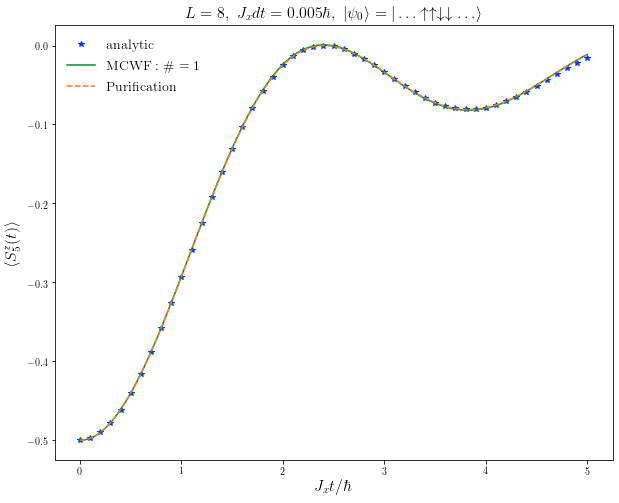

In [111]:
# https://arxiv.org/pdf/cond-mat/0409692.pdf 
# Eq. (4)
sites = np.arange(start=0, stop=p['N'], step=1) - int(p['N']/2 - 1)
i = int(p['N']/2)
for order in range(sites[i]):
    if order == 0:
        analytics = -0.5 * scipy.special.jn(order, mcwf['Time'])**2
    else:
        analytics += -0.5 * scipy.special.jn(order, mcwf['Time'])**2
        analytics += -0.5 * scipy.special.jn(-order, mcwf['Time'])**2

# plot
fig= plt.figure(figsize=(10,8))
plt.plot(mcwf['Time'][::20], analytics[::20], '*', label=r'$\rm{analytic}$')
plt.plot(mcwf['Time'], np.real(mcwf['Sz(%i)_MCav' % (i)]), '-', \
         label=r'$\rm{MCWF:} ~ \# = %s$' % (p['MCSamples']))
plt.plot(pure['Time'], np.real(pure['Sz(%i)' % (i)]), '--', \
         label=r'$\rm{Purification}$')

plt.xlabel('$ J_{x}t/\hbar $', fontsize=16)
plt.ylabel(r'$\langle S^{z}_{%i}(t) \rangle$' % (i+1), fontsize=16)
plt.legend(loc=2, fontsize=14);
plt.title(r'$L=%i, ~ J_{x}dt = %.3f \hbar, ~ $' % (p['N'],p['dt']) + \
          r'$|\psi_{0}\rangle = |\dots\uparrow\uparrow\downarrow\downarrow\dots\rangle$', fontsize=16);
plt.savefig('Test1_XXModel_HamiltonianDynamics_L%i_Sz_Site%i.pdf' % (p['N'], i+1))

### Test 2: Single Spin driving with spontaneous emmision noise

In [138]:
# define system parameters
p = {}

# XXZ parameters
p['N'] = 1 # system size
p['Symmetry'] = None # full Hilbert space
p['hx'] = -1.0 # (global) transverse field
p['hz'] = 0.0 # (global) longitudinal field
p['Jx'] = 0.0 # (global) spin-flip coupling
p['Jz'] = 0.0 # (global) nearest neighbour spin-spin interaction
p['tol'] = 1e-20 # tolerance in QFI calculation on eigenvalues

# Dissipation parameters
p['gamma_Sp'] = 0.0
p['gamma_Sm'] = 1/6.
p['gamma_Sx'] = 0.0
p['gamma_Sy'] = 0.0
p['gamma_Sz'] = 0.0

# evolution parameters
p['t_initial'] = 0.0
p['dt'] = 0.01 # time step
p['t_final'] = 15.0

# Monte-Carlo samples
p['MCSamples'] = 500

In [139]:
# Quantum Trajectory Evolution
tic = time.time()
state_table = generate_state_table(p)
# start in down
psi0 = [0]
mcwf, state_table = MonteCarloScheduler(p, state_table, psi0, kind="list")
toc = time.time()
print("MCWF evolution took ", toc-tic, "s")

MCWF evolution took  1072.3806006908417 s


In [140]:
# Purification Evolution
tic = time.time()
pure, state_table = evolve_purification(p, state_table, psi0, kind="list")
toc = time.time()
print("Purification evolution took ", toc-tic, "s")

Purification evolution took  2.7418711185455322 s


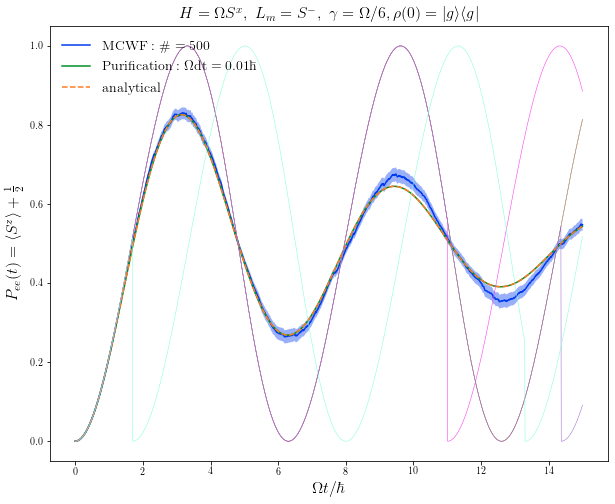

In [141]:
# plot
fig= plt.figure(figsize=(10,8))
plt.plot(mcwf['Time'], np.real(mcwf['Sz(0)_MCav']) + 0.5, label=r'$\rm{MCWF:} ~ \# = %s$' % (p['MCSamples']))
plt.fill_between(mcwf['Time'], \
                 np.real(mcwf['Sz(0)_MCav']) + 0.5 - np.real(mcwf['Sz(0)_MCsd']), \
                 np.real(mcwf['Sz(0)_MCav']) + 0.5 + np.real(mcwf['Sz(0)_MCsd']), alpha=0.4)
plt.plot(pure['Time'], np.real(pure['Sz(0)'] + 0.5), '-', \
         label=r'$\rm{Purification:} ~ \Omega dt = %.2f \hbar$' % (p['dt']))
Omega = np.sqrt(p['hx']**2 - (p['gamma_Sm']/4)**2)
amplitude = p['hx']**2 / (p['gamma_Sm']**2 + 2*p['hx']**2)
oscillations = np.cos(Omega * pure['Time']) + (3*p['gamma_Sm']/(4*Omega)) * np.sin(Omega * pure['Time'])
plt.plot(pure['Time'], amplitude * (1 - np.exp(-3*p['gamma_Sm']*pure['Time']/4)*oscillations), '--', \
        label=r'$\rm{analytical}$')
for i in range(5):
    plt.plot(mcwf['Time'], np.real(mcwf['Sz(0)'][i,:]) + 0.5, linewidth=0.5)
plt.xlabel('$\Omega t/\hbar$', fontsize=16)
plt.ylabel(r'$P_{ee}(t) = \langle S^{z} \rangle + \frac{1}{2}$', fontsize=16)
plt.legend(loc=2, fontsize=14);
plt.title(r'$H = \Omega S^{x}, ~ L_{m} = S^{-}, ~ \gamma = \Omega/%.f, \rho (0) = |g\rangle \langle g|$' % \
          (1/p['gamma_Sm']), fontsize=16);
# plt.savefig('Test2_RabiOscillations_with_SpontaneousEmission_exactUeff.pdf')
plt.savefig('Test2_RabiOscillations_with_SpontaneousEmission_1storderUeff.pdf')

### Test 3: QFI = 4Var for pure state

In [222]:
# define system parameters
p = {}

# XXZ parameters
p['N'] = 4 # system size
p['Symmetry'] = None # full Hilbert space
p['hx'] = 0.5 # (global) transverse field
p['hz'] = 0.1 # (global) longitudinal field
p['Jx'] = 1.0 # (global) spin-flip coupling
p['Jz'] = 2.0 # (global) nearest neighbour spin-spin interaction
p['tol'] = 1e-20 # tolerance in QFI calculation on eigenvalues

# Dissipation parameters
p['gamma_Sp'] = 0.0
p['gamma_Sm'] = 0.0
p['gamma_Sx'] = 0.0
p['gamma_Sy'] = 0.0
p['gamma_Sz'] = 0.0

# evolution parameters
p['t_initial'] = 0.0
p['dt'] = 0.001 # time step
p['t_final'] = 5.0

# Monte-Carlo samples
p['MCSamples'] = 1

In [223]:
# Quantum Trajectory Evolution
tic = time.time()
state_table = generate_state_table(p)
# start in down
psi0 = [0 if np.mod(i,2) == 0 else 1 for i in range(p['N'])]
mcwf, state_table = MonteCarloScheduler(p, state_table, psi0, kind="list")
toc = time.time()
print("MCWF evolution took ", toc-tic, "s")

MCWF evolution took  58.33217978477478 s


In [224]:
# Purification Evolution
tic = time.time()
pure, state_table = evolve_purification(p, state_table, psi0, kind="list")
toc = time.time()
print("Purification evolution took ", toc-tic, "s")

Purification evolution took  105.36634111404419 s


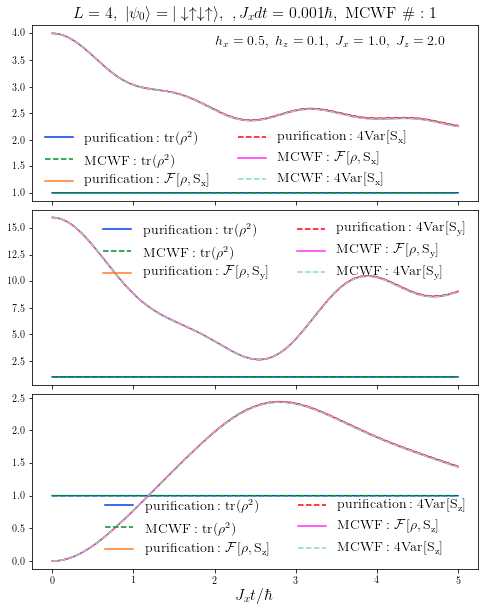

In [298]:
# plot
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(8,10))
plt.subplots_adjust(hspace=0.05)

# Sx
ax[0].plot(pure['Time'], np.real(pure['Purity']), label=r'$\rm{purification:} ~ \rm{tr}(\rho^{2})$')
ax[0].plot(mcwf['Time'], np.real(mcwf['Purity'][0,:]), '--', label=r'$\rm{MCWF:} ~ \rm{tr}(\rho^{2})$')

ax[0].plot(pure['Time'], np.real(pure['QFI_TotalSx']), label=r'$\rm{purification:} ~\mathcal{F}[\rho,S_{x}]$')
ax[0].plot(pure['Time'], 4*np.real(pure['Var(TotalSx)']), '--', label=r'$\rm{purification:} ~4\rm{Var}[S_{x}]$')


ax[0].plot(mcwf['Time'], np.real(mcwf['QFI_TotalSx'][0,:]), label=r'$\rm{MCWF:} ~\mathcal{F}[\rho,S_{x}]$')
ax[0].plot(mcwf['Time'], 4*np.real(mcwf['Var(TotalSx)'][0,:]), '--', label=r'$\rm{MCWF:} ~4\rm{Var}[S_{x}]$')

# Sy
ax[1].plot(pure['Time'], np.real(pure['Purity']), label=r'$\rm{purification:} ~ \rm{tr}(\rho^{2})$')
ax[1].plot(mcwf['Time'], np.real(mcwf['Purity'][0,:]), '--', label=r'$\rm{MCWF:} ~ \rm{tr}(\rho^{2})$')

ax[1].plot(pure['Time'], np.real(pure['QFI_TotalSy']), label=r'$\rm{purification:} ~\mathcal{F}[\rho,S_{y}]$')
ax[1].plot(pure['Time'], 4*np.real(pure['Var(TotalSy)']), '--', label=r'$\rm{purification:} ~4\rm{Var}[S_{y}]$')

ax[1].plot(mcwf['Time'], np.real(mcwf['QFI_TotalSy'][0,:]), label=r'$\rm{MCWF:} ~ \mathcal{F}[\rho,S_{y}]$')
ax[1].plot(mcwf['Time'], 4*np.real(mcwf['Var(TotalSy)'][0,:]), '--', label=r'$\rm{MCWF:} ~4\rm{Var}[S_{y}]$')

# Sz
ax[2].plot(pure['Time'], np.real(pure['Purity']), label=r'$\rm{purification:} ~ \rm{tr}(\rho^{2})$')
ax[2].plot(mcwf['Time'], np.real(mcwf['Purity'][0,:]), '--', label=r'$\rm{MCWF:} ~ \rm{tr}(\rho^{2})$')

ax[2].plot(pure['Time'], np.real(pure['QFI_TotalSz']), label=r'$\rm{purification:} ~ \mathcal{F}[\rho,S_{z}]$')
ax[2].plot(pure['Time'], 4*np.real(pure['Var(TotalSz)']), '--', label=r'$\rm{purification:} ~4\rm{Var}[S_{z}]$')

ax[2].plot(mcwf['Time'], np.real(mcwf['QFI_TotalSz'][0,:]), label=r'$\rm{MCWF:} ~ \mathcal{F}[\rho,S_{z}]$')
ax[2].plot(mcwf['Time'], 4*np.real(mcwf['Var(TotalSz)'][0,:]), '--', label=r'$\rm{MCWF:} ~4\rm{Var}[S_{z}]$')

ax[2].set_xlabel(r'$J_{x}t/\hbar$', fontsize=16);
ax[0].legend(loc=3, ncol=2, fontsize=14);
ax[1].legend(loc=1, ncol=2, fontsize=14);
ax[2].legend(loc=4, ncol=2, fontsize=14);
ax[0].set_title(r'$L = %i,~ |\psi_{0}\rangle = |\downarrow\uparrow\downarrow\uparrow\rangle, ~$' % (p['N']) + \
                r'$, J_{x}dt = %.3f\hbar, ~ \rm{MCWF} ~ \#: %i$'% (p['dt'], p['MCSamples']), fontsize=16);
ax[0].text(2.0, 3.75, r'$h_{x}=%.1f,~h_{z}=%.1f,~J_{x}=%.1f,~J_{z}=%.1f$' % \
           (p['hx'],p['hz'],p['Jx'],p['Jz']), fontsize=14);
plt.savefig('Test3_QFI_Variance_Equivalence_PurestateNoDissipation.pdf')

### Test 4: QFI for GS of Heisenberg chain is maximal

In [128]:
# define system parameters
p = {}

# XXZ parameters
p['N'] = 10 # system size
p['Symmetry'] = None # which Sz quantum number sector (full Hilbert space = None)
p['hx'] = 0.0 # (global) transverse field
p['hz'] = 0.0 # (global) longitudinal field
p['Jx'] = 1.0 # (global) spin-flip coupling
p['Jz'] = 1 - 1e-8 # (global) nearest neighbour spin-spin interaction
p['tol'] = 1e-20 # tolerance in QFI calculation on eigenvalues

# Dissipation parameters
p['gamma_Sp'] = 0.0
p['gamma_Sm'] = 0.0
p['gamma_Sx'] = 0.0
p['gamma_Sy'] = 0.0
p['gamma_Sz'] = 0.0

# evolution parameters
p['t_initial'] = 0.0
p['dt'] = 0.0 # time step
p['t_final'] = 0.0

# Monte-Carlo samples
p['MCSamples'] = 1

In [129]:
# build Hamiltonian
state_table = generate_state_table(p)
H = make_Hamiltonian(p, state_table)

# compute GS
E0, GS = LA.eigsh(H, k=1, which='SA')

# build generator
for i in range(p['N']):
    if i == 0:
        Sx = Sx_matrix(p, i, state_table)
        Sz = Sz_matrix(p, i, state_table)
    else:
        Sx += Sx_matrix(p, i, state_table)
        Sz += Sz_matrix(p, i, state_table)

# compute QFI for the generator
QFI = quantum_fisher_info(build_densitymatrix(GS), Sx, p['tol'])[0]

# compute variance of generator
Var = (expct_val(Sx.dot(Sx), GS)[0][0] - expct_val(Sx, GS)**2)[0][0]

# GS upper bound
QFI_max = 4 * (p['N']/2) * (p['N']/2 + 1) / 2

print(len(state_table), E0, QFI/(p['N']**2), 4*np.real(Var)/(p['N']**2), QFI_max/(p['N']**2))

1024 [-2.25] 0.5999989882337406 0.5999989882337382 0.6


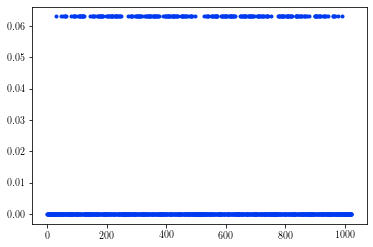

In [130]:
plt.plot(np.abs(GS), '.')